# Ideas on City Bike Challenge

Based on the data available at [Divvy Data](https://www.divvybikes.com/system-data), how to guess where people usually live and where the usually work? This notebook suggests some directions and shows some results.

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## The data

[Divvy Data](https://www.divvybikes.com/system-data) publishes a sample of the data. 

In [ ]:
from pyensae.datasource import download_data
file = download_data("Divvy_Trips_2016_Q3Q4.zip", url="https://s3.amazonaws.com/divvy-data/tripdata/")

We know the stations.

In [ ]:
import pandas
stations = df = pandas.read_csv("Divvy_Stations_2016_Q3.csv")
df.head()

,id,name,latitude,longitude,dpcapacity,online_date
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013
4,80,Aberdeen St & Monroe St,41.880420,-87.655599,19,6/26/2013


And we know the trips.

In [ ]:
bikes = df = pandas.read_csv("Divvy_Trips_2016_Q3.csv")
df.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,12150160,9/30/2016 23:59:58,10/1/2016 00:04:03,4959,245,69,Damen Ave & Pierce Ave,17,Wood St & Division St,Subscriber,Male,1988.0
1,12150159,9/30/2016 23:59:58,10/1/2016 00:04:09,2589,251,383,Ashland Ave & Harrison St,320,Loomis St & Lexington St,Subscriber,Female,1990.0
2,12150158,9/30/2016 23:59:51,10/1/2016 00:24:51,3656,1500,302,Sheffield Ave & Wrightwood Ave,334,Lake Shore Dr & Belmont Ave,Customer,NaN,NaN
3,12150157,9/30/2016 23:59:51,10/1/2016 00:03:56,3570,245,475,Washtenaw Ave & Lawrence Ave,471,Francisco Ave & Foster Ave,Subscriber,Female,1988.0
4,12150156,9/30/2016 23:59:32,10/1/2016 00:26:50,3158,1638,302,Sheffield Ave & Wrightwood Ave,492,Leavitt St & Addison St,Customer,NaN,NaN


## First assumption

Which time do you go to work? How do you go to work? Maybe by bicycles, maybe in the morning, everyday... Let's see the distribution of the stop time in every station of one particular day of the week.

In [ ]:
import pandas
from datetime import datetime, time
df["dtstart"] = pandas.to_datetime(df.starttime, infer_datetime_format=True)
df["dtstop"] = pandas.to_datetime(df.stoptime, infer_datetime_format=True)
df["stopday"] = df.dtstop.apply(lambda r: datetime(r.year, r.month, r.day))
df["stoptime"] = df.dtstop.apply(lambda r: time(r.hour, r.minute, 0))
df["stoptime10"] = df.dtstop.apply(lambda r: time(r.hour, (r.minute // 10)*10, 0))  # every 10 minutes

In [ ]:
df['stopweekday'] = df['dtstop'].dt.dayofweek

### Big stations

We average the number of the number of bicycles which stops at the station.

In [ ]:
key = ["to_station_name", "to_station_id", "stopday"]
perday = df[key + ["trip_id"]].groupby(key, as_index=False).count()
ave = perday.groupby(key[:-1], as_index=False).mean()
ave.columns = "to_station_name", "to_station_id", "mean stops per day"
ave.head()

,to_station_name,to_station_id,mean stops per day
0,2112 W Peterson Ave,456,2.532468
1,63rd St Beach,101,6.316456
2,900 W Harrison St,109,17.347826
3,Aberdeen St & Jackson Blvd,21,36.402174
4,Aberdeen St & Monroe St,80,40.793478


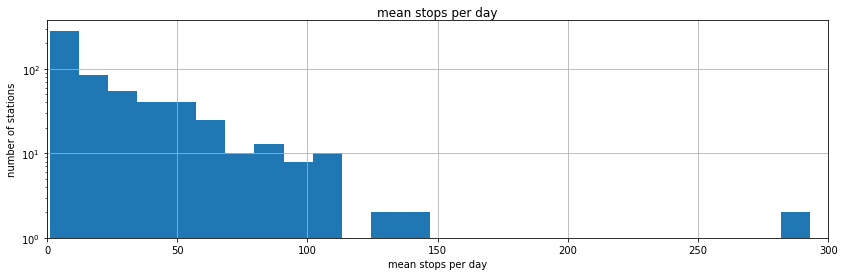

In [ ]:
ax = ave["mean stops per day"].hist(bins=50, figsize=(14,4))
ax.set_xlim([0, 300])
ax.set_yscale("log")
ax.set_title("mean stops per day")
ax.set_xlabel("mean stops per day")
ax.set_ylabel("number of stations")

In [ ]:
ave[ave["mean stops per day"] > 20].shape, ave.shape

((236, 3), (581, 3))

In [ ]:
df.dtstop.min(), df.dtstop.max()

(Timestamp('2016-07-01 00:03:37'), Timestamp('2016-10-01 09:24:02'))

For about half of the stations, more than 20 bicycles stops between July and October of 2016. Let's take one of them.

In [ ]:
ave[ave["mean stops per day"] > 20].head()

,to_station_name,to_station_id,mean stops per day
3,Aberdeen St & Jackson Blvd,21,36.402174
4,Aberdeen St & Monroe St,80,40.793478
5,Ada St & Washington Blvd,346,34.728261
6,Adler Planetarium,341,114.478261
9,Albany Ave & Bloomingdale Ave,511,20.913043


In [ ]:
key = ["to_station_name", "to_station_id", "stopweekday", "stoptime10"]
snippet = df[key + ["trip_id"]].groupby(key, as_index=False).count()
snippet.columns = "to_station_name", "to_station_id", "stopweekday", "stoptime10", "nb_stops"
snippet21 = snippet[snippet["to_station_id"] == 21].copy()
snippet21.head()

,to_station_name,to_station_id,stopweekday,stoptime10,nb_stops
925,Aberdeen St & Jackson Blvd,21,0,05:10:00,4
926,Aberdeen St & Jackson Blvd,21,0,06:00:00,1
927,Aberdeen St & Jackson Blvd,21,0,06:10:00,4
928,Aberdeen St & Jackson Blvd,21,0,06:20:00,2
929,Aberdeen St & Jackson Blvd,21,0,06:40:00,1


In [ ]:
snippet21.tail()

,to_station_name,to_station_id,stopweekday,stoptime10,nb_stops
1621,Aberdeen St & Jackson Blvd,21,6,22:10:00,7
1622,Aberdeen St & Jackson Blvd,21,6,22:20:00,1
1623,Aberdeen St & Jackson Blvd,21,6,22:30:00,2
1624,Aberdeen St & Jackson Blvd,21,6,22:50:00,1
1625,Aberdeen St & Jackson Blvd,21,6,23:40:00,1


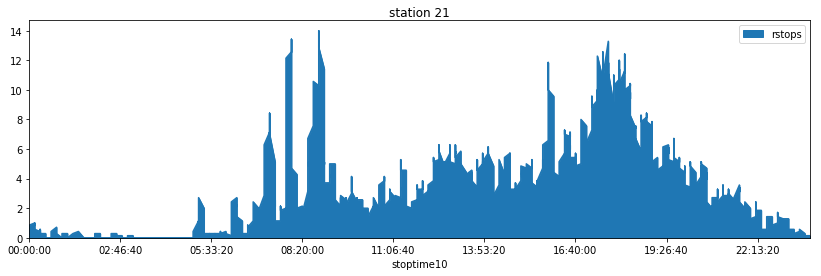

In [ ]:
from ensae_projects.datainc.data_bikes import add_missing_time
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(14,4))
full_snippet21 = add_missing_time(snippet21, "stoptime10", delay=10, values="nb_stops")
full_snippet21["rstops"] = full_snippet21.nb_stops.rolling(7).mean()
full_snippet21.plot(x="stoptime10", y="rstops", figsize=(14,4), kind="area", ax=ax)
ax.set_title("station 21")

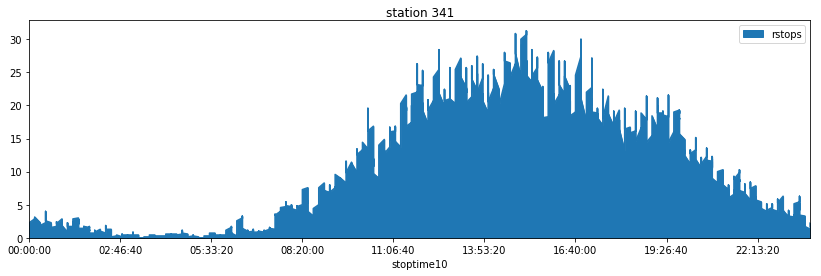

In [ ]:
from ensae_projects.datainc.data_bikes import add_missing_time
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(14,4))
sni = snippet[snippet["to_station_id"] == 341].copy()
sni = add_missing_time(sni, "stoptime10", delay=10, values="nb_stops")
sni["rstops"] = sni.nb_stops.rolling(7).mean()
sni.plot(x="stoptime10", y="rstops", figsize=(14,4), kind="area", ax=ax)
ax.set_title("station 341")

### Indicator

If a station is inside working area, people will arrive in the morning and will leave in the evening. If it is a living area, people should leave in the morning and arrive in the evening. Let's note $L_t$ the number of bicyles leaving a station. Let's compute the ratio:

$$R = \frac{\sum_{t=8am}^{12am} L_t}{\sum_{t=0am}^{12pm} L_t}$$

In [ ]:
R21 = full_snippet21.nb_stops[(full_snippet21["stoptime10"] > time(8,0,0)) & (full_snippet21["stoptime10"] < time(12,0,0))].sum() /  \
      full_snippet21.nb_stops[full_snippet21["stoptime10"] >= time(0,0,0)].sum()
R21

0.1803523439832786

In [ ]:
key = ["to_station_name", "to_station_id", "stopweekday", "stoptime10"]
agg = bikes[key + ["trip_id"]].groupby(key, as_index=False).count().copy()

ratios = {}
for ids in set(stations.id):
    sni = agg[agg["to_station_id"] == ids]
    sni.columns = "to_station_name", "to_station_id", "stopweekday", "stoptime10", "nb_stops"
    num = sni.nb_stops[(sni["stoptime10"] >= time(8,0,0)) & (sni["stoptime10"] <= time(12,0,0))].sum()
    den = sni.nb_stops[sni["stoptime10"] >= time(0,0,0)].sum()
    if den > 0:
        ratios[ids] = num * 1.0 / den

In [ ]:
import numpy
stations_ratio = stations.copy()
stations_ratio["ratio"] = stations.id.apply(lambda x: ratios.get(x, numpy.nan))
stations_ratio.head()

,id,name,latitude,longitude,dpcapacity,online_date,ratio
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015,0.102564
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015,0.254509
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013,0.392231
3,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,6/21/2013,0.196178
4,80,Aberdeen St & Monroe St,41.880420,-87.655599,19,6/26/2013,0.192379


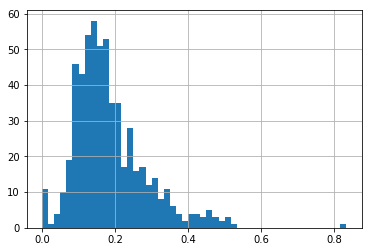

In [ ]:
stations_ratio["ratio"].hist(bins=50)

We choose the median.

In [ ]:
stations_ratio.ratio.median()

0.1648655139289145

And we draw a map.

In [ ]:
from ensae_projects.datainc.data_bikes import folium_html_stations_map
xy = []
for els in stations_ratio.apply(lambda row: (row["latitude"], row["longitude"], row["ratio"], row["name"]), axis=1):
    name = "%s %1.2f" % (els[3], els[2])
    color = "red" if els[2] >= 0.1648655139289145 else "blue"
    xy.append( ( (els[0], els[1]), (name, color)))
folium_html_stations_map(xy, width="80%")

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x1e205714be0>

If we assume that people have bigger flats than working space, we should assume there are more living areas than working areas.

In [ ]:
stations_ratio.ratio.quantile(0.6)

0.18241042345276873

In [ ]:
from ensae_projects.datainc.data_bikes import folium_html_stations_map
xy = []
for els in stations_ratio.apply(lambda row: (row["latitude"], row["longitude"], row["ratio"], row["name"]), axis=1):
    name = "%s %1.2f" % (els[3], els[2])
    color = "red" if els[2] >= 0.18241042345276873 else "blue"
    xy.append( ( (els[0], els[1]), (name, color)))
folium_html_stations_map(xy, width="80%")

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x1e205459940>